# Making stacked histograms
- processes an `events[year][ch][sample]` object using `make_events_dict()`
- uses `plot_hists()` to make stacked histograms

In [1]:
import glob
import os
import json
import pickle
import pickle as pkl
import yaml
import math

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'had': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [4]:
def get_lumi(years, channels):
    lum_ = 0
    for year in years:
        lum = 0
        for ch in channels:
            lum += luminosity[ch][year] / 1000.0

        lum_ += lum / len(channels)    
    return lum_

In [93]:
 # define your regions here
presel = {
        "mu": {
            "lepmiso": "(lep_pt<55) | ( (lep_pt>=55) & (lep_misolation<0.8) )",   # needed for the fakes            
#             "preselection": "(fj_mass>40)",
            "preselection + tagger": "(fj_mass>40) & (THWW>0.75)",
#             "FakeValidation": "fj_mass>30 & fj_mass<40",
        },
        "ele": {
#             "preselection": "(fj_mass>40)",
            "preselection + tagger": "(fj_mass>40) & (THWW>0.75)",
#             "FakeValidation": "fj_mass>30 & fj_mass<40",
        },
}

channels = [
    "ele",
    "mu",
]
samples = [
#     "ggF", 
#     "VBF",  
#     "WH",
#     "ZH",
#     "ttH",
    
#     "QCD",
#     "WJetsLNu",
    "TTbar",
#     "SingleTop",
#     "Diboson",
#     "EWKvjets",
#     "DYJets",
#     "WZQQ",

#     "Data",
#     "Fake",
]

years = [
#     "2016",
#     "2016APV",
    "2017",
#     "2018",
]

In [94]:
samples_dir = {
    "2016":    "../eos/hww/Dec20_hww_2016",
    "2016APV": "../eos/hww/Dec20_hww_2016APV",
    "2017":    "../eos/hww/Dec20_hww_2017",
    "2018":    "../eos/hww/Dec20_hww_2018",
    
#     "2017":    "../eos/hww/Jun5_hww_2017",    
}

THWW_path = "../../weaver-core-dev/experiments_finetuning/v35_30/model.onnx"

from make_stacked_hists import make_events_dict, fix_neg_yields

events_dict = make_events_dict(years, channels, samples_dir, samples, presel, THWW_path, fake_SF={"ele": 0.75, "mu": 1})

INFO:root:Processing 2017, ele channel
INFO:root:Processing 2017, mu channel


In [56]:
df = {}

for year in years:
    l = []
    for ch in ["ele","mu",]:
        for sample in [
#             "ggF",
#             "VBF",
#             "WJetsLNu",
            "TTbar",
        ]:
            l += [events_dict[year][ch][sample]]
    df[year] = pd.concat(l)

In [97]:
df = events_dict["2017"]["ele"]["TTbar"]["fj_isTop_W_ele"][events_dict['2017']['ele']['TTbar']['THWW']>0.905]
df.sum() / len(df)

0.905717151454363

In [69]:
df = events_dict["2017"]["ele"]["WJetsLNu"]["fj_V_isMatched"]
df.sum() / len(df)

0.0

In [91]:
df = events_dict["2017"]["mu"]["WJetsLNu"]["fj_V_isMatched"]
df.sum()

0

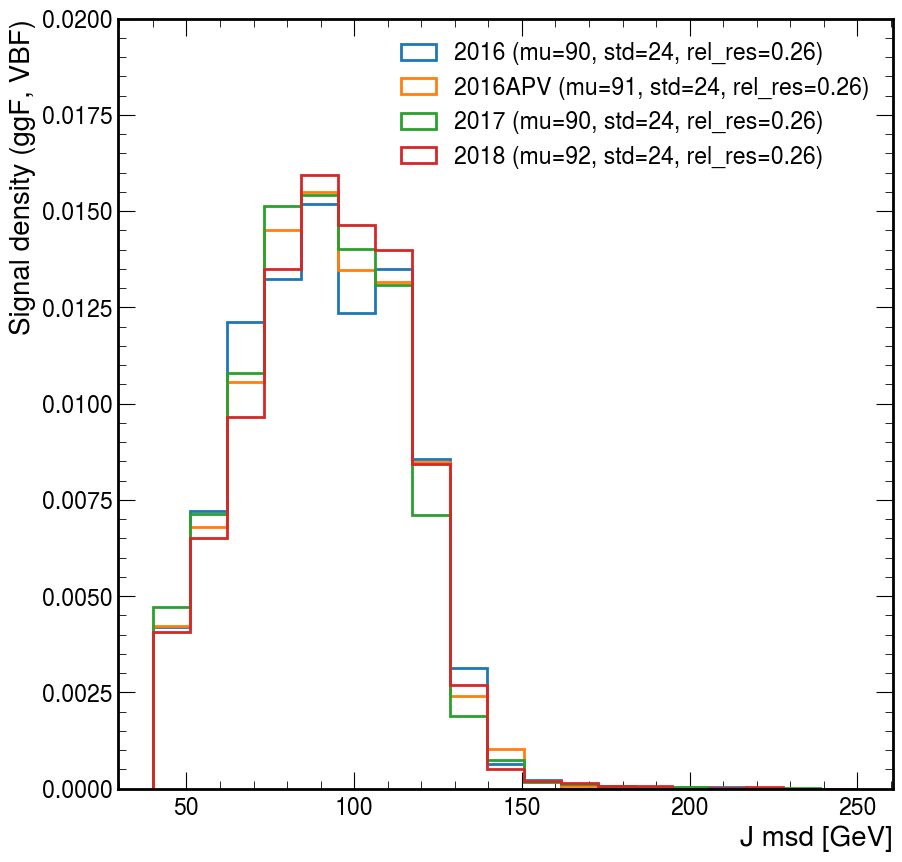

In [29]:
bins = np.linspace(40,250,20)

plt.figure()

for year in years:
    mu = df[year]["fj_mass"].mean()
    std = df[year]["fj_mass"].std()
    plt.hist(
      df[year]["fj_mass"], bins=bins, histtype="step", lw=2, label=f"{year} (mu={mu:.0f}, std={std:.0f}, rel_res={(std/mu):.2f})",density=True
    )

plt.legend()
plt.xlabel("J msd [GeV]")
plt.ylabel("Signal density (ggF, VBF)")
plt.ylim(0,0.020)

plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/JMS-JMR/rel_res.pdf")       

Text(1, 0, 'J msd [GeV]')

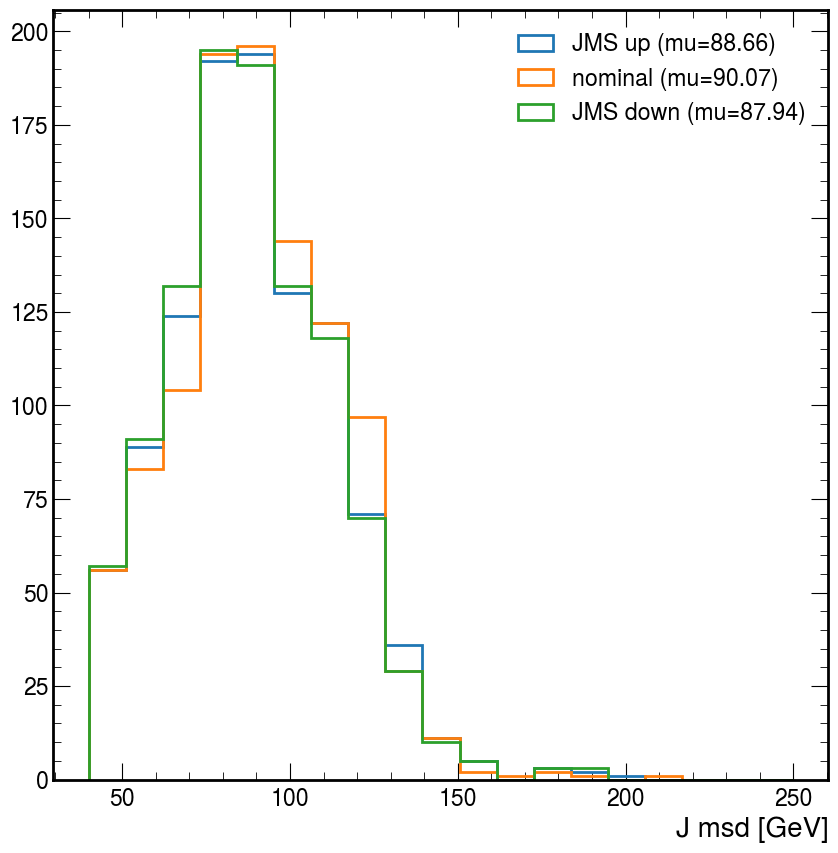

In [9]:
df = events_dict['2017']['ele']['ggF']
bins = np.linspace(40,250,20)

plt.figure()


mu = df["fj_massJMS_up"].mean()
plt.hist(
  df["fj_massJMS_up"], bins=bins, histtype="step", lw=2, label=f"JMS up (mu={mu:.2f})",
)

mu = df["fj_mass"].mean()
plt.hist(
  df["fj_mass"], bins=bins, histtype="step", lw=2, label=f"nominal (mu={mu:.2f})",
)

mu = df["fj_massJMS_down"].mean()
plt.hist(
  df["fj_massJMS_down"], bins=bins, histtype="step", lw=2, label=f"JMS down (mu={mu:.2f})",
)

plt.legend()
plt.xlabel("J msd [GeV]")

Text(1, 0, 'J msd [GeV]')

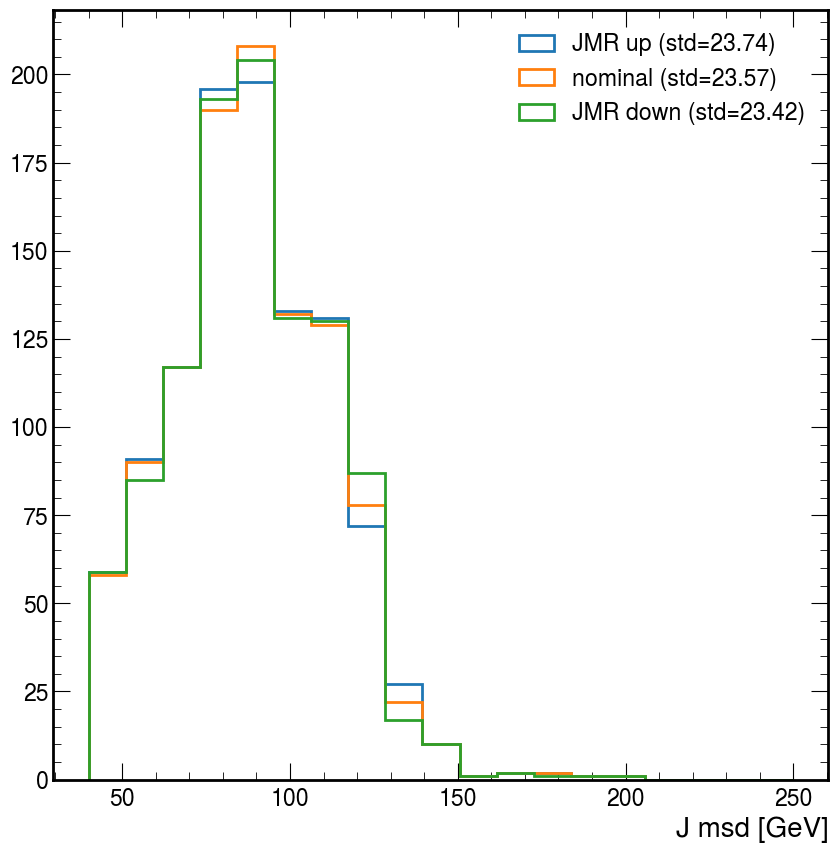

In [14]:
df = events_dict['2017']['ele']['ggF']
bins = np.linspace(40,250,20)

plt.figure()


std = df["fj_massJMR_up"].std()
plt.hist(
  df["fj_massJMR_up"], bins=bins, histtype="step", lw=2, label=f"JMR up (std={std:.2f})",
)

std = df["fj_mass"].std()
plt.hist(
  df["fj_mass"], bins=bins, histtype="step", lw=2, label=f"nominal (std={std:.2f})",
)

std = df["fj_massJMR_down"].std()
plt.hist(
  df["fj_massJMR_down"], bins=bins, histtype="step", lw=2, label=f"JMR down (std={std:.2f})",
)

plt.legend()
plt.xlabel("J msd [GeV]")

# Stacked hists

In [25]:
from syst_unc_utils import (
    fill_syst_unc_hists,
    get_total_syst_unc,
    initialize_syst_unc_hists,
)

vars_to_plot = [
    
#     "dR_genlep_recolep", 
        ############# AN start
#         "FirstFatjet_pt",
#         "fj_lsf3",
#         "fj_mass",
#         "fj_ParT_mass",
#         "fj_pt",
#         "ht",
#         "lep_fj_dr",  
#         "lep_isolation_ele_highpt",
#         "lep_isolation_ele_lowpt",
#         "lep_isolation_mu_highpt",
#         "lep_isolation_mu_lowpt",
#         "lep_met_mt",
#         "lep_misolation_ele_highpt",
#         "lep_misolation_ele_lowpt",
#         "lep_misolation_mu_highpt",
#         "lep_misolation_mu_lowpt",
#         "lep_pt",
#         "lep_eta",
#         "met_fj_dphi",
#         "met_pt",
#         "NumFatjets",
#         "NumOtherJets",
#         "rec_higgs_m",
#         "rec_W_lnu_m",
#         "rec_W_qq_m",
#         "SecondFatjet_pt",
#         "met_phi",    
#         "THWW",
        ############## AN end

        ############## Fake vs QCD
#         "fj_pt",
#         "lep_pt",
#         "met_pt",
#         "lep_fj_dr",
#         "THWW",
    
        ############## Control regions
        "fj_pt",
#         "lep_pt",
#         "lep_fj_dr",
#         "met_pt",
        "rec_higgs_m",

        ############## Fake validation region
#         "fj_pt",
#         "lep_pt",
#         "lep_eta",
#         "met_pt",
    
        # more
#         "fj_lsf3",
#         "rec_higgs_m",
#         "fj_mass",
    #     "fj_ParT_mass",
#         "fj_pt",
    #     "lep_fj_dr",
    #     "met_pt",
    #     "rec_W_lnu_m",
    #     "rec_W_qq_m",
    #     "met_phi",
#         "rec_higgs_pt",
#         "lep_eta",
#     "rho",
#     "pt_ratio",
#     "mjj",  
#     "deta",
#     "fj_VScore",
#     "SecondFatjet_Vscore",
]

samples_to_plot = [
        "ggF",
        "VBF",
        "ttH",
        "WH",
        "ZH",
#         "Fake",
        "SingleTop",
        "DYJets",
        "WZQQ",    
        "Diboson",
        "EWKvjets",
        "TTbar",
        "WJetsLNu",
#         "WJetsLNu_LO",    
        "Data",
    
#     "QCD",
    
#     "TTbar_is_top_lq",
#     "TTbar_is_top_lqq",
#     "TTbar_others",
    
#     "WJetsLNu_unmatched",
#     "WJetsLNu_matched",
]


years_to_plot = [
    "2016",
    "2016APV",
    "2017",
    "2018",
]

channels_to_plot = [
        "ele",
        "mu",
]

plot_syst_unc = True
massbin = 20

if plot_syst_unc:
    import sys

    sys.path.append("../combine/")
    from systematics import get_systematic_dict

    SYST_DICT = get_systematic_dict(years_to_plot)
    
    SYST_UNC_up, SYST_UNC_down = {}, {}
    SYST_hists = initialize_syst_unc_hists(SYST_DICT, {"years_to_plot": years_to_plot, "vars_to_plot": vars_to_plot, "massbin": massbin})  

In [33]:
WP_ggF = 0.93
WP_VBF = 0.905

region_sel = {
#     "Pre-selection": "(fj_mass>40) & (THWW>0.75)",   # dummy
#     "Fake validation": "fj_mass>30 & fj_mass<40",
#     "SR": f"THWW>{WP_VBF} & (n_bjets_T==0)",
#     "Top CR": f"(n_bjets_T>0) & THWW>0.9",
    "WJets CR": f"(n_bjets_T==0) & (THWW<0.905) & (rec_higgs_pt>250) & (NumFatjets>=2)",
}
region, sel = list(region_sel.items())[0]

shift = 50
categories_sel = {
#     "VBF category": f"( (THWW>{WP_VBF}) & (n_bjets_T==0) ) & ( (mjj>1000) & (deta>3.5) )",

#     "ggF category": f"( (THWW>{WP_ggF}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) ) & (VH_fj_VScore<0.9)",    
    
#     r"ggF $p_T \in $ " + f"[{200+shift}, {300+shift}]": f"( (THWW>{WP_ggF}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (rec_higgs_pt<{300+shift}) ) & (VH_fj_VScore<0.9)",
#     r"ggF $p_T \in $ " + f"[{300+shift}, {450+shift}]": f"( (THWW>{WP_ggF}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (rec_higgs_pt>{300+shift}) & (rec_higgs_pt<{450+shift}) ) & (VH_fj_VScore<0.9)",
#     r"ggF $p_T \in $ " + f"[{450+shift}, Inf]": f"( (THWW>{WP_ggF}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (rec_higgs_pt>{450+shift}) ) & (VH_fj_VScore<0.9)",      
}

num, den = 0, 0
threshold = 0

# fill histograms
import utils
from utils import get_axis

# instantiate nominal histograms
hists = {}
for var_to_plot in vars_to_plot:
    
    hists[var_to_plot] = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        utils.get_axis(var_to_plot,massbin),
        storage=hist2.storage.Weight(),
    )

# start filling the histograms
for var_to_plot in vars_to_plot:    
    for year in years_to_plot:
        for ch in channels_to_plot:
            for sample in samples_to_plot:   

#                 # -------------- some samples may be split during plotting to matched/unmatched
#                 if "TTbar" in sample:
                    
#                     if "TTbar_LP" in sample:
#                         df = pd.read_parquet(f"../LP/LP_TTbar_{year}_{ch}.parquet")
#                         df["nominal"] = df["LP_weight_nom"]
#                     else:
#                         df = pd.read_parquet(f"../LP/LP_TTbar_{year}_{ch}.parquet")           
                    
                    # TODO
#                     df = events_dict[year][ch]["TTbar"]

#                     ########## seperate topologies by color                    
#                     is_top_lq = (df["fj_Top_nquarksnob"]==1) & (df["fj_Top_nbquarks"]==0)                        
#                     is_top_lqq = (df["fj_Top_nquarksnob"]==2) & (df["fj_Top_nbquarks"]==0)

#                     if (sample == "TTbar_is_top_lq"):
#                         df = df[is_top_lq]
#                     elif (sample == "TTbar_is_top_lqq"):
#                         df = df[is_top_lqq]
#                     elif (sample == "TTbar_others"):
#                         df = df[~(is_top_lq | is_top_lqq)]

                df = events_dict[year][ch][sample]
                df = df.query(sel)
                                     
                if len(categories_sel)>=1:
                    category, category_sel = list(categories_sel.items())[0]
                    df = df.query(category_sel)

                # ----------- some variables need manual tweaking
                if "lep_isolation_ele" in var_to_plot:
                    if ch != "ele":
                        continue
                    df = df[(df["lep_pt"] > 120)] if "highpt" in var_to_plot else df[(df["lep_pt"] < 120)]
                    df[var_to_plot] = df["lep_isolation"]

                elif "lep_isolation_mu" in var_to_plot:
                    if ch != "mu":
                        continue
                    df = df[(df["lep_pt"] > 55)] if "highpt" in var_to_plot else df[(df["lep_pt"] < 55)]
                    df[var_to_plot] = df["lep_isolation"]

                elif "lep_misolation_ele" in var_to_plot:
                    if ch != "ele":
                        continue
                    df = df[(df["lep_pt"] > 120)] if "highpt" in var_to_plot else df[(df["lep_pt"] < 120)]
                    df[var_to_plot] = df["lep_misolation"]

                elif "lep_misolation_mu" in var_to_plot:
                    if ch != "mu":
                        continue
                    df = df[(df["lep_pt"] > 55)] if "highpt" in var_to_plot else df[(df["lep_pt"] < 55)]
                    df[var_to_plot] = df["lep_misolation"]


                hists[var_to_plot].fill(
                    samples=sample,
                    var=df[var_to_plot],
                    weight=df["nominal"],
                )

                if plot_syst_unc:
                    SYST_hists_sig = fill_syst_unc_hists(SYST_DICT, SYST_hists, year, ch, sample, var_to_plot, df)

    fix_neg_yields(hists[var_to_plot])
    
    if plot_syst_unc:
        SYST_UNC_up[var_to_plot], SYST_UNC_down[var_to_plot] = get_total_syst_unc(
            SYST_hists[var_to_plot]
        )
        
        sys_keys = ["sys", "prongs", "unclust", "distortion"]
        for sys_key in sys_keys:
            up = SYST_hists_sig[var_to_plot]["up"][f"LP_weight_{sys_key}"].values()
            down = SYST_hists_sig[var_to_plot]["down"][f"LP_weight_{sys_key}"].values()

            SYST_hists[var_to_plot]["up"][f"LP_weight_{sys_key}"].view().value = np.maximum(up, down)
            SYST_hists[var_to_plot]["down"][f"LP_weight_{sys_key}"].view().value = np.minimum(up, down)

Will plot fj_pt histogram
#bins: 30, chi_square: 43.613, reduced_chi_square: 1.504
Will plot rec_higgs_m histogram
#bins: 8, chi_square: 3.062, reduced_chi_square: 0.437


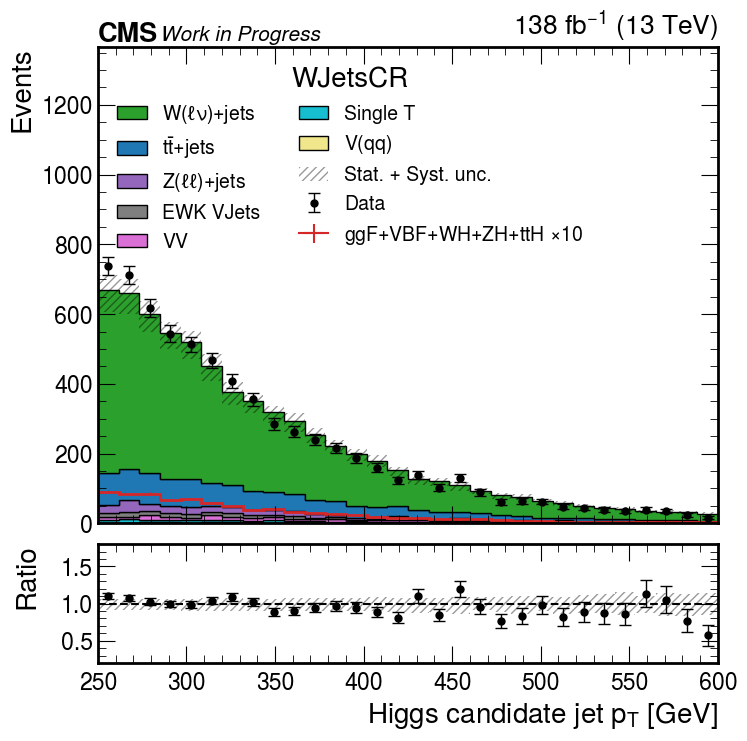

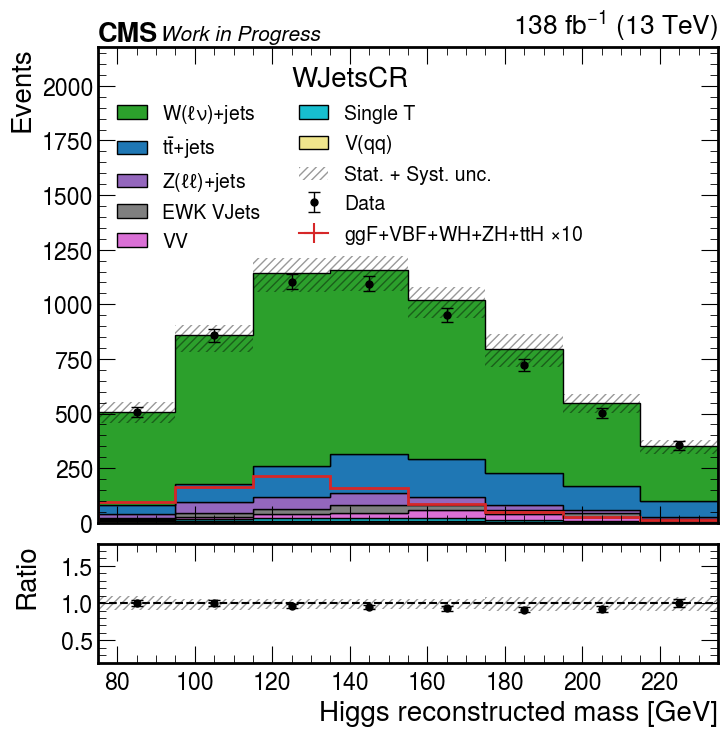

In [34]:
plt.rcParams.update({"font.size": 20})
add_data = True

if "SR" in region or ("Signal region") in region:
    blind_region=[90,160]
    mult = 10
else:
    blind_region=False
    mult = 1

if "VBF category" in categories_sel:
    mult = 5


from utils import plot_hists as plot_hists
# PATH = f"/Users/fmokhtar/Desktop/AN_2024/ARC/eletriggerSF/with_trgSF/"
# PATH = f"/Users/fmokhtar/Desktop/AN_2024/ARC/WJetsCR_pt500toInf/"
# PATH = f"/Users/fmokhtar/Desktop/AN_2024/ARC/WJetsCR_pt350to500/"
# PATH = f"/Users/fmokhtar/Desktop/AN_2024/ARC/WJetsCR_pt250to350/"
PATH = f"/Users/fmokhtar/Desktop/AN_2024/ARC/WJetsCR/"

# PATH = f"/Users/fmokhtar/Desktop/AN_2024/lol"


if not os.path.exists(PATH):
    os.makedirs(PATH)    

nice_ch = {
    "ele": "Electron",
    "mu": "Muon",
}

plot_hists(hists, years_to_plot, channels_to_plot, vars_to_plot,
            add_data=True,
            logy=False,
            mult=10,
            outpath=PATH,
#             text_=f"{nice_ch[ch]} channel",
#            text_="WJetsCR (recoH pt 500toInf)",
#            text_="WJetsCR (recoH pt 350to500)",
#            text_="WJetsCR (recoH pt 250to350)",
           text_="WJetsCR",           
#             text_=list(region_sel.items())[0][0],
#             text_=list(region_sel.items())[0][0] + " (w/o Nick and EWK corr)",
#             text_=list(region_sel.items())[0][0] + " (w/ k-factor applied)",
#             text_=list(categories_sel.items())[0][0] + " (w/ k-factor applied)",
            blind_region=blind_region,
            plot_Fake_unc=0.25,
            plot_syst_unc=(SYST_UNC_up, SYST_UNC_down) if plot_syst_unc else None,
           add_soverb=False,
           legend_ncol=2,
#            seperate_Fake_unc=True,
           plot_totsig=True,
           plot_sig_components=False,
          )

In [36]:
`dd

{'2016': {'ele': {'EWKvjets':       fj_lsf3  fj_VScore      lep_pt   lep_eta   lep_phi  lep_mass  \
   88   0.985840   0.921011  294.684998  0.740356 -0.573486 -0.061127   
   130  0.920898   0.882579   51.230175 -1.623535  0.217957  0.046173   
   172  0.941895   0.971518  127.189423  1.604980  2.929199 -0.073303   
   174  0.705566   0.927914  151.525314 -0.963257  0.188568  0.051636   
   285  0.979980   0.986852   80.580727  1.219238  0.824829  0.046356   
   286  0.609375   0.975708   82.374268  1.899902 -0.271912 -0.047699   
   347  0.942383   0.760749  194.651962  0.292236  1.968750  0.031555   
   377  0.967285   0.861425  119.454773 -1.186279  2.324219 -0.024231   
   444  0.954102   0.912003  173.717209 -0.372498  1.524658  0.029083   
   450  0.978027   0.592517  260.059204  1.741211 -0.260925 -0.132202   
   514  0.969727   0.627200   81.305038 -0.391846 -3.078125 -0.008209   
   543  0.987793   0.925725  212.259827  0.739990  1.122070 -0.085571   
   583  0.992188   0.897

# Make yield composition table

In [362]:
def make_composition_table(ev, presel, add_soverb=False, use_Fake=False):

    from collections import OrderedDict
    
    all_MCsamples = [
        "ggF", 
        "VBF",
        "ttH",
        "WH",
        "ZH",        
        "WJetsLNu",
        "TTbar",
        "SingleTop",
        "Diboson",
        "EWKvjets",
        "DYJets",
        "WZQQ",
    ]
    if use_Fake:    
        all_MCsamples += ["Fake"]
        bkg = ["TTbar", "WJetsLNu", "Fake", "Others"]        
    else:
        all_MCsamples += ["QCD"]
        bkg = ["TTbar", "WJetsLNu", "QCD", "Others"]        
    
    sig = ["VBF", "ggF", "WH", "ZH", "ttH"]

    mass_window = [50, 150]
    
    # make table
    print("\\begin{table}[!ht]")
    print("\\begin{center}")
    
    if add_soverb:
        print("\\caption{Event yield contribution from different processes in the search regions for the full Run2 dataset. The last column includes $s/\sqrt{b}$ in a mass window of 100-150\GeV in the mass observable (the Higgs reconstructed mass).}")
    else:
        print("\\caption{Event yield contribution from different processes in the search regions for the full Run2 dataset.}")
        
    if add_soverb:
        print("\\begin{tabular}{c|ccccc|cccc|c}")
    else:
        print("\\begin{tabular}{c|ccccc|cccc}")

    if add_soverb:    
        print("& \\multicolumn{5}{c|}{Signal yield} & \\multicolumn{4}{c|}{Background yield} & \\multicolumn{1}{c}{$s/\sqrt{b}$} \\\\\n")
        if use_Fake:
            print("& VBF & ggF & WH & ZH & \\ttH & \\ttbar & W$+$jets & Fake & Other & \\\\\n")
        else:
            print("& VBF & ggF & WH & ZH & \\ttH & \\ttbar & W$+$jets & QCD & Other & \\\\\n")
    else:
        print("& \\multicolumn{5}{c|}{Signal yield} & \\multicolumn{4}{c}{Background yield} \\\\\n")
        if use_Fake:        
            print("& VBF & ggF & WH & ZH & \\ttH & \\ttbar & W$+$jets & Fake & Other \\\\\n")
        else:
            print("& VBF & ggF & WH & ZH & \\ttH & \\ttbar & W$+$jets & QCD & Other \\\\\n")
            
    print("\\hline")
    print("\\hline")

    years_to_cover = years
    for region, sel in presel.items():
        if sel == 0:
            print("\\hline")
            continue
            
        if "2018" in region:
            years_to_cover = ["2018"]
        elif "2017" in region:
            years_to_cover = ["2017"]
        elif "2017" in region:
            years_to_cover = ["2017"]
        elif "2016APV" in region:
            years_to_cover = ["2016APV"]
        elif "2016" in region:
            years_to_cover = ["2016"]
        else:
            years_to_cover = years
        
        sig_dict = OrderedDict({
            "VBF": 0,
            "ggF": 0,
            "WH": 0,
            "ZH": 0,
            "ttH": 0,            
        })

        if use_Fake:           
            bkg_dict = OrderedDict({
                "TTbar": 0,
                "WJetsLNu": 0, 
                "Fake": 0,
                "Others": 0,    
            })
        else:
            bkg_dict = OrderedDict({
                "TTbar": 0,
                "WJetsLNu": 0, 
                "QCD": 0,
                "Others": 0,    
            })            

        tot_sig, tot_bkg = 0, 0
        s, b = 0, 0   # in mass window [100, 150]
        for year in years_to_cover:
            for ch in channels:
                for sample in all_MCsamples:
                    
                    df = ev[year][ch][sample]

                    df = df.query(sel)  

                    if sample in sig_dict:
                        tot_sig += df["nominal"].sum()                    
                        sig_dict[sample] += df["nominal"].sum()
                    elif sample in bkg_dict:
                        tot_bkg += df["nominal"].sum()
                        bkg_dict[sample] += df["nominal"].sum()
                    else:
                        tot_bkg += df["nominal"].sum()                        
                        bkg_dict["Others"] += df["nominal"].sum()                    

                    ######################## soverb start
                    df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]

                    if sample in sig_dict:                
                        s += df["nominal"].sum()
                    else:
                        b += df["nominal"].sum()
                    ######################## soverb end

        texdata = "\multirow{2}{*}{" + region + "} & \multicolumn{5}{c|}{"
        texdata += str(round(tot_sig))
        
        if add_soverb:
            texdata += "} & \multicolumn{4}{c|}{"
            texdata += str(round(tot_bkg))
            texdata += "} & \multicolumn{1}{c}{"            
#             texdata += str(round(s/(b**0.5),3))
            texdata += "\multirow{2}{*}{" + str(round(s/(b**0.5),3)) + "}"
            
            texdata += "} \\\\\n"
        else:
            texdata += "} & \multicolumn{4}{c}{"
            texdata += str(round(tot_bkg))
            texdata += "} \\\\\n"
        
#         texdata += "\\cline{2-9} \n"
        
        for sample in sig_dict:
            texdata += f" & {(100*sig_dict[sample]/tot_sig):.0f}\%"
#             texdata += f" & {(sig_dict[sample]):.2f}"
            
        for sample in bkg_dict:
            if bkg_dict[sample]<0:
                bkg_dict[sample]=0
            texdata += f" & {(100*bkg_dict[sample]/tot_bkg):.0f}\%"
#             texdata += f" & {(bkg_dict[sample]):.2f}"            
        
        if add_soverb:
            texdata += " & "

        texdata += " \\\\\n"
        print(texdata)
        print("\\hline")

    print("\\hline")
    print("\\end{tabular}")
    print("\\label{tab:}")
    print("\\end{center}")
    print("\\end{table}")      

In [19]:
shift = 50
WP_VBF = 0.905
WP_ggF = 0.93

presel = {
#     "Pre-selection": f"THWW>0", # dummy    
    
#     "Top CR": f"n_bjets_T>0", # dummy
    
#     "bveto": f"n_bjets_T==0", # dummy

    
#     "Signal region": f"(THWW>0.92) & (n_bjets_T==0)",    
#     "Top control region": f"(THWW>0.75) & (n_bjets_T>0)",
#     "W+Jets control region": f"(THWW<0.905) & (THWW>0.75) & (n_bjets_T==0)",

#     "VBF category": f"( (THWW>{WP_VBF}) & (n_bjets_T==0) ) & ( (mjj>1000) & (deta>3.5) & (NumOtherJets>=2) )",
    
#     r"ggF category $p_T \in $ " + f"[{200+shift}, {300+shift}]": f"( (THWW>{WP_ggF}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) | (NumOtherJets<2) ) & (rec_higgs_pt<{300+shift}) ) & (VH_fj_VScore<0.9)",
#     r"ggF category $p_T \in $ " + f"[{300+shift}, {450+shift}]": f"( (THWW>{WP_ggF}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) | (NumOtherJets<2) ) & (rec_higgs_pt>{300+shift}) & (rec_higgs_pt<{450+shift}) ) & (VH_fj_VScore<0.9)",
#     r"ggF category $p_T \in $ " + f"[{450+shift}, Inf]": f"( (THWW>{WP_ggF}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) | (NumOtherJets<2) ) & (rec_higgs_pt>{450+shift}) ) & (VH_fj_VScore<0.9)",      
    

    "Top control region (RUN2)": f"(THWW>0.9) & (n_bjets_T>0)",
    "Top control region (2018)": f"(THWW>0.9) & (n_bjets_T>0)",
    "Top control region (2017)": f"(THWW>0.9) & (n_bjets_T>0)",
    "Top control region (2016)": f"(THWW>0.9) & (n_bjets_T>0)",
    "Top control region (2016APV)": f"(THWW>0.9) & (n_bjets_T>0)",
    
#     "W+Jets control region (RUN2)": f"(THWW<0.90) & (THWW>0.75) & (n_bjets_T==0)",
#     "W+Jets control region (2018)": f"(THWW<0.90) & (THWW>0.75) & (n_bjets_T==0)",
#     "W+Jets control region (2017)": f"(THWW<0.90) & (THWW>0.75) & (n_bjets_T==0)",
#     "W+Jets control region (2016)": f"(THWW<0.90) & (THWW>0.75) & (n_bjets_T==0)",
#     "W+Jets control region (2016APV)": f"(THWW<0.90) & (THWW>0.75) & (n_bjets_T==0)",
}

make_composition_table(events_dict, presel, add_soverb=False, use_Fake=True)

\begin{table}[!ht]
\begin{center}
\caption{Event yield contribution from different processes in the search regions for the full Run2 dataset.}
\begin{tabular}{c|ccccc|cccc}
& \multicolumn{5}{c|}{Signal yield} & \multicolumn{4}{c}{Background yield} \\

& VBF & ggF & WH & ZH & \ttH & \ttbar & W$+$jets & Fake & Other \\

\hline
\hline
\multirow{2}{*}{Top control region (RUN2)} & \multicolumn{5}{c|}{9} & \multicolumn{4}{c}{452} \\
 & 7\% & 27\% & 3\% & 11\% & 51\% & 79\% & 12\% & 0\% & 11\% \\

\hline
\multirow{2}{*}{Top control region (2018)} & \multicolumn{5}{c|}{4} & \multicolumn{4}{c}{204} \\
 & 6\% & 26\% & 3\% & 11\% & 54\% & 80\% & 11\% & 0\% & 10\% \\

\hline
\multirow{2}{*}{Top control region (2017)} & \multicolumn{5}{c|}{2} & \multicolumn{4}{c}{138} \\
 & 5\% & 28\% & 4\% & 12\% & 51\% & 78\% & 11\% & 0\% & 13\% \\

\hline
\multirow{2}{*}{Top control region (2016)} & \multicolumn{5}{c|}{1} & \multicolumn{4}{c}{47} \\
 & 9\% & 27\% & 5\% & 11\% & 48\% & 79\% & 11\% & 0\% & 12\% \\

In [80]:
# this one skips the Fake altogether (relevant to signal region)

def make_composition_table(ev, presel, add_soverb=False):

    from collections import OrderedDict
    
    all_MCsamples = [
        "ggF", 
        "VBF",
        "ttH",
        "WH",
        "ZH",        
        "WJetsLNu",
        "TTbar",
        "SingleTop",
        "Diboson",
        "EWKvjets",
        "DYJets",
        "WZQQ",
    ]
    
    bkg = ["TTbar", "WJetsLNu", "Others"]
    sig = ["VBF", "ggF", "WH", "ZH", "ttH"]

    mass_window = [50, 150]
    
    # make table
    print("\\begin{table}[!ht]")
    print("\\begin{center}")
    
    if add_soverb:
        print("\\caption{Event yield contribution from different processes in the search regions for the full Run2 dataset. The last column includes $s/\sqrt{b}$ in a mass window of 100-150\GeV in the mass observable (the Higgs reconstructed mass).}")
    else:
        print("\\caption{Event yield contribution from different processes in the search regions for the full Run2 dataset.}")
        
    if add_soverb:
        print("\\begin{tabular}{c|ccccc|ccc|c}")
    else:
        print("\\begin{tabular}{c|ccccc|ccc}")

    if add_soverb:    
        print("& \\multicolumn{5}{c|}{Signal yield} & \\multicolumn{3}{c|}{Background yield} & \\multicolumn{1}{c}{$s/\sqrt{b}$} \\\\\n")
        print("& VBF & ggF & WH & ZH & \\ttH & \\ttbar & W$+$jets & Other & \\\\\n")
    else:
        print("& \\multicolumn{5}{c|}{Signal yield} & \\multicolumn{3}{c}{Background yield} \\\\\n")
        print("& VBF & ggF & WH & ZH & \\ttH & \\ttbar & W$+$jets & Other \\\\\n")
            
    print("\\hline")
    print("\\hline")

    years_to_cover = years
    for region, sel in presel.items():
        if sel == 0:
            print("\\hline")
            continue
            
        if "2018" in region:
            years_to_cover = ["2018"]
        elif "2017" in region:
            years_to_cover = ["2017"]
        elif "2017" in region:
            years_to_cover = ["2017"]
        elif "2016APV" in region:
            years_to_cover = ["2016APV"]
        elif "2016" in region:
            years_to_cover = ["2016"]
        else:
            years_to_cover = years
        
        sig_dict = OrderedDict({
            "VBF": 0,
            "ggF": 0,
            "WH": 0,
            "ZH": 0,
            "ttH": 0,            
        })
    
        bkg_dict = OrderedDict({
            "TTbar": 0,
            "WJetsLNu": 0, 
            "Others": 0,    
        })  

        tot_sig, tot_bkg = 0, 0
        s, b = 0, 0   # in mass window [100, 150]
        for year in years_to_cover:
            for ch in channels:
                for sample in all_MCsamples:
                    
                    df = ev[year][ch][sample]

                    df = df.query(sel)  

                    if sample in sig_dict:
                        tot_sig += df["nominal"].sum()                    
                        sig_dict[sample] += df["nominal"].sum()
                    elif sample in bkg_dict:
                        tot_bkg += df["nominal"].sum()
                        bkg_dict[sample] += df["nominal"].sum()
                    else:
                        tot_bkg += df["nominal"].sum()                        
                        bkg_dict["Others"] += df["nominal"].sum()                    

                    ######################## soverb start
                    df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]

                    if sample in sig_dict:                
                        s += df["nominal"].sum()
                    else:
                        b += df["nominal"].sum()
                    ######################## soverb end

        texdata = "\multirow{2}{*}{" + region + "} & \multicolumn{5}{c|}{"
        texdata += str(round(tot_sig))
        
        if add_soverb:
            texdata += "} & \multicolumn{3}{c|}{"
            texdata += str(round(tot_bkg))
            texdata += "} & \multicolumn{1}{c}{"            
#             texdata += str(round(s/(b**0.5),3))
            texdata += "\multirow{2}{*}{" + str(round(s/(b**0.5),3)) + "}"
            
            texdata += "} \\\\\n"
        else:
            texdata += "} & \multicolumn{3}{c}{"
            texdata += str(round(tot_bkg))
            texdata += "} \\\\\n"
        
#         texdata += "\\cline{2-9} \n"
        
        for sample in sig_dict:
#             texdata += f" & {(100*sig_dict[sample]/tot_sig):.0f}\%"
            texdata += f" & {(sig_dict[sample]):.2f}"

        
        for sample in bkg_dict:
            if bkg_dict[sample]<0:
                bkg_dict[sample]=0
#             texdata += f" & {(100*bkg_dict[sample]/tot_bkg):.0f}\%"
            texdata += f" & {(bkg_dict[sample]):.2f}"            
        
        if add_soverb:
            texdata += " & "

        texdata += " \\\\\n"
        print(texdata)
        print("\\hline")

    print("\\hline")
    print("\\end{tabular}")
    print("\\label{tab:}")
    print("\\end{center}")
    print("\\end{table}")      
    
# shift = 50
# WP_VBF = 0.905
# WP2 = 0.93

# presel = {
#     "VBF category": f"( (THWW>{WP_VBF}) & (n_bjets_T==0) ) & ( (mjj>1000) & (deta>3.5) )",
    
#     r"ggF category $p_T \in $ " + f"[{200+shift}, {300+shift}]": f"( (THWW>{WP2}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (rec_higgs_pt<{300+shift}) ) & (VH_fj_VScore<0.9)",
#     r"ggF category $p_T \in $ " + f"[{300+shift}, {450+shift}]": f"( (THWW>{WP2}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (rec_higgs_pt>{300+shift}) & (rec_higgs_pt<{450+shift}) ) & (VH_fj_VScore<0.9)",
#     r"ggF category $p_T \in $ " + f"[{450+shift}, Inf]": f"( (THWW>{WP2}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (rec_higgs_pt>{450+shift}) ) & (VH_fj_VScore<0.9)",      
# }

# make_composition_table(events_dict, presel, add_soverb=True)    

In [84]:
shift = 50
WP_VBF = 0.905
WP2 = 0.93

presel = {    
    "VBF category": f"( (THWW>0.905) & (n_bjets_T==0) ) & ( (mjj>1000) & (deta>3.5) )",
    
    r"ggF 250to350": f"( (THWW>0.93) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (rec_higgs_pt<350) )",
    r"ggF 350to500": f"( (THWW>0.93) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (rec_higgs_pt>350) & (rec_higgs_pt<500) )",
    r"ggF 500toInf": f"( (THWW>0.93) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (rec_higgs_pt>500) )",        
}

make_composition_table(events_dict, presel, add_soverb=False)

\begin{table}[!ht]
\begin{center}
\caption{Event yield contribution from different processes in the search regions for the full Run2 dataset.}
\begin{tabular}{c|ccccc|ccc}
& \multicolumn{5}{c|}{Signal yield} & \multicolumn{3}{c}{Background yield} \\

& VBF & ggF & WH & ZH & \ttH & \ttbar & W$+$jets & Other \\

\hline
\hline
\multirow{2}{*}{VBF category} & \multicolumn{5}{c|}{9} & \multicolumn{3}{c}{52} \\
 & 7.58 & 1.63 & 0.06 & 0.03 & 0.06 & 17.42 & 28.70 & 5.93 \\

\hline
\multirow{2}{*}{ggF 250to350} & \multicolumn{5}{c|}{9} & \multicolumn{3}{c}{163} \\
 & 1.87 & 5.05 & 0.95 & 0.52 & 0.30 & 50.32 & 92.97 & 19.83 \\

\hline
\multirow{2}{*}{ggF 350to500} & \multicolumn{5}{c|}{17} & \multicolumn{3}{c}{251} \\
 & 2.68 & 10.76 & 1.85 & 1.14 & 0.69 & 85.86 & 127.55 & 37.46 \\

\hline
\multirow{2}{*}{ggF 500toInf} & \multicolumn{5}{c|}{7} & \multicolumn{3}{c}{138} \\
 & 1.31 & 4.77 & 0.72 & 0.45 & 0.24 & 38.10 & 77.85 & 21.65 \\

\hline
\hline
\end{tabular}
\label{tab:}
\end{center}
\end{t